In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import os
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
hun = pd.read_html("https://koronavirus.gov.hu/elhunytak")[0]
hun = hun.rename(columns={
   'Sorszám': 'id',
    'Nem': 'gender',
    'Kor': 'age',
    'Alapbetegségek': 'conditions'
})
hun = hun.drop('id', axis=1)

len(hun)

32

# Általános statisztikák

In [3]:
print("Összes elhunyt:", len(hun))
print("Átlagéletkor:", hun.age.mean())
print("Medián életkor:", hun.age.median())
print("Életkor szórása:", hun.age.std().round(1))
gc = hun.gender.value_counts()
print("Férfi: {}, Nő: {}".format(gc.loc['Férfi'], gc.loc['Nő']))

Összes elhunyt: 32
Átlagéletkor: 75.03125
Medián életkor: 78.5
Életkor szórása: 14.1
Férfi: 19, Nő: 13


In [4]:
death_count = pd.read_table("death_count.tsv", index_col="day", parse_dates=['day'])
today = pd.Timestamp.today().date().strftime("%Y-%m-%d")
if today not in death_count.index:
    death_count.loc[today, "cnt"] = len(hun)
death_count.to_csv("death_count.tsv", sep="\t")

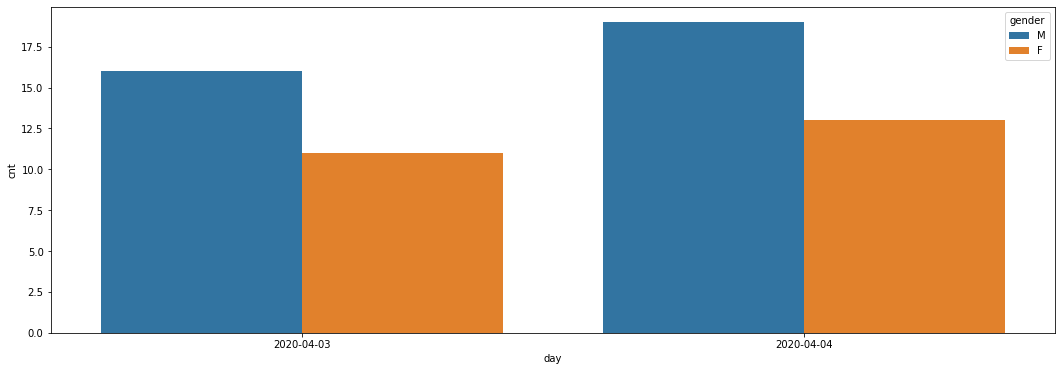

In [5]:
fig, ax = plt.subplots(1, figsize=(18, 6))
d = death_count[['M', 'F']].stack()
d.name = 'cnt'
d = d.reset_index().rename(columns={'level_1': 'gender'})
d['day'] = d.day.dt.date
sns.barplot(x=d.day, y=d.cnt, hue=d.gender, ax=ax)

# Korosztályonként

In [6]:
labels = ['under 40', '40-49', '50-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-90', 'over 90']
hun['age_group'] = pd.cut(hun.age, bins=[0, 39, 49, 59, 64, 69, 74, 79, 84, 89, 120], labels=labels)

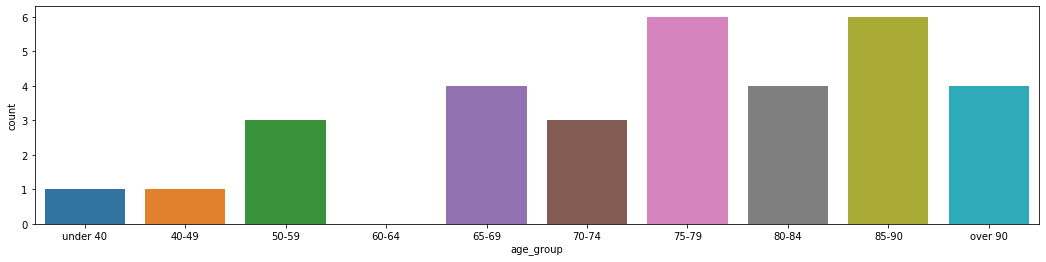

In [7]:
fig, ax = plt.subplots(1, figsize=(18, 4))
sns.countplot(hun.age_group, ax=ax)

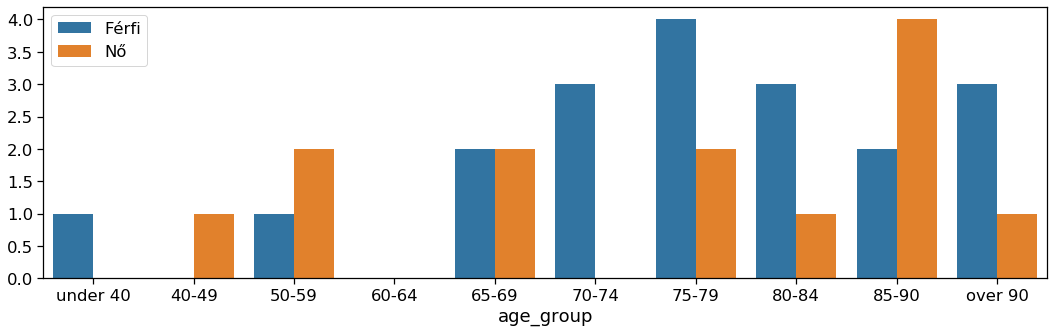

In [8]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(18, 5))
    h = hun.groupby(['gender', 'age_group']).size().reset_index()
    h = h.rename(columns={0: 'cnt'})
    sns.barplot(x=h.age_group, y=h.cnt, hue=h.gender, ax=ax)
    ax.legend(title="", loc='upper left')
    ax.set_ylabel("")

# Alapbetegségek

In [9]:
name_mapping = {}
with open("name_mapping.tsv") as f:
    for line in f:
        fd = line.strip().split("\t")
        name_mapping[fd[0]] = fd[1]

list_of_conditions = []

def split_conditions(conditions):
    for c in conditions.split(","):
        c = c.strip()
        if not c:
            continue
        c = name_mapping.get(c, c)
        list_of_conditions.append(c)
        
hun.conditions.apply(split_conditions)

lc = Counter(list_of_conditions)
conditions = pd.Series(lc)
conditions = conditions.reset_index().rename(columns={'index': 'condition', 0: 'cnt'})

categories = pd.read_table("categories.tsv", names=['condition', 'category'], skiprows=1)

conditions = conditions.merge(categories, on='condition')

# 10 leggyakoribb betegség

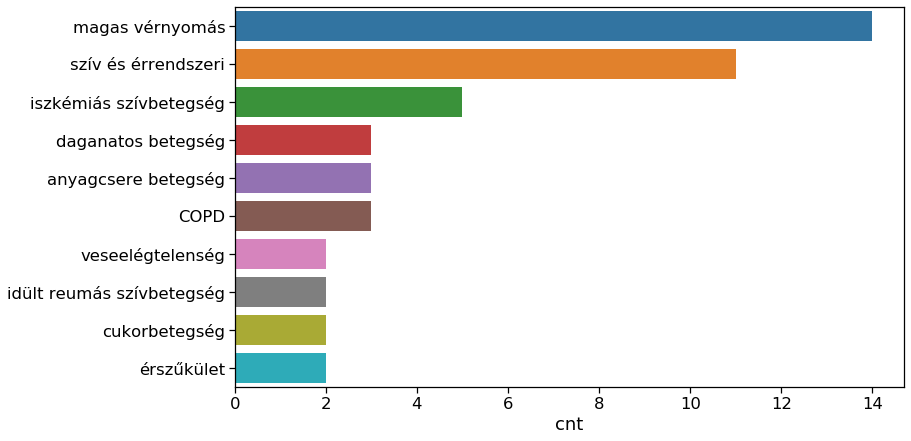

In [10]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.sort_values('cnt', ascending=False).head(10)
    sns.barplot(y=common.condition, x=common.cnt, ax=ax)
    _ = ax.set_ylabel("")

# Kategóriák

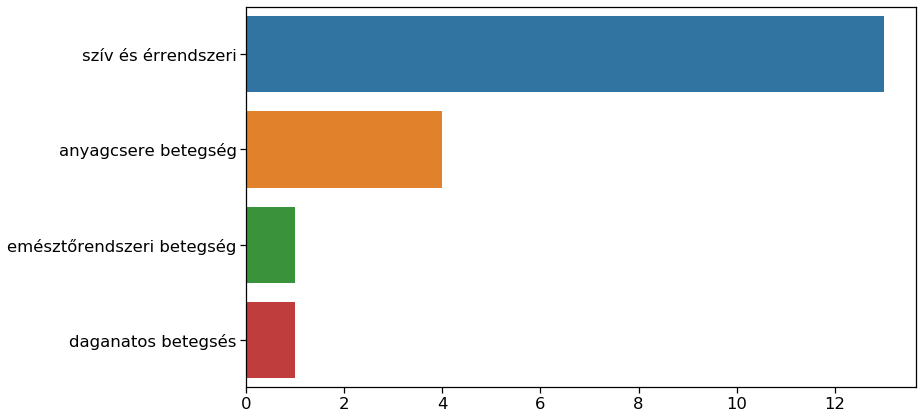

In [11]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    cc = conditions.category.value_counts()
    sns.barplot(y=cc.index, x=cc, ax=ax)
    _ = ax.set_xlabel("")